## kWTA_ei
This program explores the implementation of a kWTA network using a E-I network.

Sergio Verduzco,               
October 2017

In [1]:
from draculab import *
from matplotlib import pyplot as plt
import time
from matplotlib.animation import FuncAnimation

In [2]:
class ei_net():
    def __init__(self):
        """ All the default parameter dictionaries are below. """
        # parameter dictionary for the network
        self.net_params = {'min_delay' : 0.1, # notice delays below are set using this value
                           'min_buff_size' : 5 } 
        # parameter dictionary for the excitatory units
        self.unit_pars = {'init_val' : 0.5, 
                          'slope' : 2.,
                          'thresh' : 1.,
                          'tau' : 0.1,
                          'tau_fast' : 0.2,
                          'tau_slow' : 1.,
                          'type' : unit_types.sigmoidal }
        # geometry dictionary for both excitatory and inhibitory populations
        self.geom = {'shape':'sheet', 
                     'extent':[1.,1.], 
                     'center':[0.,0.], 
                     'arrangement':'grid', 
                     'rows':10, 
                     'columns':10, 
                     'jitter' : 0.02 }
        # parameters for the inhibitory units
        self.inh_pars = {'init_val' : 0.5, 
                         'slope' : 4.,
                         'thresh' : .5,
                         'tau' : 0.1,
                         'tau_fast' : 0.2,
                         'tau_slow' : 1.,
                         'type' : unit_types.sigmoidal } 
        # parameters for the input units
        self.n_inp = 4 # number of input units
        self.inp_pars = {'type' : unit_types.source,
                         'init_val' : 0.,
                         'tau_fast' : 0.2,
                         'function' : lambda x: None }
        # E-E connections
        self.e2e_conn = {'connection_type' : 'convergent',
            'mask' : {'circular': {'radius': 0.15}},
            'kernel' : {'gaussian' : {'p_center' : 1.1, 'sigma' : 0.3} },
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : 0.3, 'a' : 0.1}},
            'number_of_connections' : 6,
            'allow_autapses' : True,
            'allow_multapses' : False,
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']} }
        self.e2e_syn = {'type' : synapse_types.static }
        # E-I connections
        self.e2i_conn = {'connection_type' : 'convergent',
            'mask' : {'annular': {'inner_radius': 0.15, 'outer_radius': 0.4}},
            'kernel' : 1.,
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : 0.1, 'a' : 0.01}},
            #'number_of_connections' : 14,
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']} }
        self.e2i_syn = {'type' : synapse_types.static }
        # I-E connections
        self.i2e_conn = {'connection_type' : 'convergent',
            'mask' : {'circular': {'radius': 0.15}},
            'kernel' : 1,
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : -.1, 'a' : 0.001}},
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']} }
        self.i2e_syn = {'type' : synapse_types.homeo_inh,
            'lrate' : 0.1,
            'des_act' : 0.3 }
        # inputs to E and I
        self.i2u_conn_spec = {'rule' : 'all_to_all',
                 'delay' : self.net_params['min_delay'] }
        self.i2u_syn_spec = {'type' : synapse_types.bcm,
                'lrate' : 0.05,
                'init_w' : {'distribution' : 'equal_norm', 'norm' : 1.} }
        
    def build(self):
        """ Create the draculab network. """
        # Set derived parameters
        self.e2e_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.e2i_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.i2e_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.i2u_conn_spec['delay'] = self.net_params['min_delay']
        self.e2e_conn['boundary'] = {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']}
        self.e2i_conn['boundary'] = {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']}
        self.i2e_conn['boundary'] = {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']}
        # Create an auxiliary topology object
        topo = topology()
        # Create network
        self.net = network(self.net_params)
        # Create excitatory population
        self.units = topo.create_group(self.net, self.geom, self.unit_pars)
        # Create group of inhibitory units
        self.inh = topo.create_group(self.net, self.geom, self.inh_pars)
        # Create input units
        self.inp = self.net.create(self.n_inp, self.inp_pars)
        # E-E connections
        topo.topo_connect(self.net, self.units, self.units, self.e2e_conn, self.e2e_syn)
        # E-I connections
        topo.topo_connect(self.net, self.units, self.inh, self.e2i_conn, self.e2i_syn)
        # I-E connections
        topo.topo_connect(self.net, self.inh, self.units, self.i2e_conn, self.i2e_syn)
        # Connect the inputs to the units
        self.net.connect(self.inp, self.units, self.i2u_conn_spec, self.i2u_syn_spec)
        self.net.connect(self.inp, self.inh, self.i2u_conn_spec, self.i2u_syn_spec)
        
    def make_sin_pulse(self, t_init, t_end, per, amp): 
        """ This function returns a function implementing a localized sinusoidal bump(s). """
        return lambda t : amp * ( np.sqrt( 0.5 * (1. + 
                      np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) ) ) ) if (t_init < t and t < t_end) else 0.

    def input_vector(self):
        """This function returns an input vector. Different distributions can be implemented with this. """
        # right now it's just random vectors with unit norm
        vec = np.random.uniform(0., 1., self.n_inp)
        return  vec / np.linalg.norm(vec)
        
    def run(self, n_pres, pres_time):
        """ Run a simulation, presenting n_pres patterns, each lasting pres_time. 
            
            Calculates:
                self.all_times: 1-D numpy array with the times for each data point in all_activs.
                self.all_activs: 2-D numpy array with the activity of all units at each point in all_times. 
        """
        sim_time = 0. # amount of time simulated so far
        self.all_times = []
        self.all_activs = []
        start_time = time.time()
        for pres in range(n_pres):
            print('Starting presentation ' + str(pres), end='\r')
            pres_start = time.time()
            t = self.net.sim_time
            inp_vec = self.input_vector()
            for i in self.inp:
                self.net.units[i].set_function(self.make_sin_pulse(t, t+pres_time, pres_time, inp_vec[i-self.inp[0]]))
        
            times, activs, plants = self.net.run(pres_time)
            self.all_times.append(times)
            self.all_activs.append(activs)
            print('Presentation %s lasted %s seconds.' % (pres, time.time() - pres_start), end='\n')

        self.all_times = np.concatenate(self.all_times)
        self.all_activs = np.concatenate(self.all_activs, axis=1)
        print('Execution time is %s seconds' % (time.time() - start_time)) 
        
    def basic_plot(self):
        #%matplotlib inline
        inp_fig = plt.figure(figsize=(10,5))
        inputs = np.transpose([self.all_activs[i] for i in self.inp])
        plt.plot(self.all_times, inputs, linewidth=1)
        plt.title('Inputs')

        unit_fig = plt.figure(figsize=(10,5))
        some_acts = np.transpose(self.all_activs[[self.units[i] for i in [0,1,-1,-2]]])
        plt.plot(self.all_times, some_acts)
        plt.title('Some unit activities')

        inh_fig = plt.figure(figsize=(10,5))
        some_inh = np.transpose(self.all_activs[[self.inh[i] for i in [0,1,-1,-2]]])
        plt.plot(self.all_times, some_inh)
        plt.title('some inhibitory units')

        plt.show()
        
    def activ_anim(self, thr):
        """ An animation to visualize the activity of the excitatory units. 
        
            Units whose activity surpasses 'thr' will be highlighted.
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib notebook 

        self.unit_fig = plt.figure(figsize=(7,7))
        self.ax = self.unit_fig.add_axes([0, 0, 1, 1], frameon=False)
        self.ax.set_xlim(-1, 1), self.ax.set_xticks([])
        self.ax.set_ylim(-1, 1), self.ax.set_yticks([])
        xcoords = [ u.coordinates[0] for u in [self.net.units[i] for i in self.units] ]
        ycoords = [ u.coordinates[1] for u in [self.net.units[i] for i in self.units] ]
        self.scat = self.ax.scatter(xcoords, ycoords, s=20.*self.all_activs[self.units,0])
        self.n_data = len(self.all_activs[0])
        self.act_thr = thr
        animation = FuncAnimation(self.unit_fig, self.update_act_anim, 
                                  interval=100, save_count=int(round(self.net.sim_time/self.net.min_delay)))
        #plt.show()    
        return animation
        
    def color_fun(self, activ):
        # given the units activity, maps into a color. activ may be an array.
        activ =  np.maximum(0.1,  activ*np.maximum(np.sign(activ - 0.8), 0.))
        return np.outer(activ, np.array([0., .5, 1., .5]))

    def update_act_anim(self, frame):
        # Each frame advances one simulation step (min_delay time units)
        idx = frame%self.n_data
        cur_time = self.net.min_delay*idx
        self.scat.set_sizes(300.*self.all_activs[self.units,idx])
        self.scat.set_color(self.color_fun(self.all_activs[self.units,idx]))
        self.unit_fig.suptitle('Time: ' + '{:f}'.format(cur_time))
        return self.ax,

    def conn_anim(self, source, sink):
        """ An animation to visualize the connectivity of Exc. and Inh. populations. 
    
            source and sink are lists with the IDs of the units whose connections we'll
            visualize. Each frame of the animation shows: for a particular unit in source,
            all the neurons in sink that receive connections from it (left plot), and for 
            a particular unit in sink, all the units in source that send it connections
            (right plot).
        
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib notebook 
        
        # update_conn_anim uses these values
        self.len_source = len(source)
        self.len_sink = len(sink)
        self.source_0 = source[0]
        self.sink_0 = sink[0]

        # flattening net.syns, leaving only the source-sink connections 
        self.all_syns = []
        for syn_list in [self.net.syns[i] for i in sink]:
            syn_list = [s for s in syn_list if s.preID in source]
            self.all_syns += syn_list
    
        # getting lists with the coordinates of all source, sink units
        source_coords = [u.coordinates for u in [self.net.units[i] for i in source]]
        sink_coords = [u.coordinates for u in [self.net.units[i] for i in sink]]
        source_x = [c[0] for c in source_coords]
        source_y = [c[1] for c in source_coords]
        sink_x = [c[0] for c in sink_coords]
        sink_y = [c[1] for c in sink_coords]

        # setting colors
        self.std_src = [0., 0.5, 0.1, 0.5]
        self.std_snk = [1., 0.5, 0.5, 0.5]
        self.big_src = [0., 0., 0., 1.]
        self.big_snk = [0., 1., 0., 1.]

        # constructing figure, axes, path collections
        self.conn_fig = plt.figure(figsize=(9,5))
        self.ax1 = self.conn_fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.ax2 = self.conn_fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.src_col1 = self.ax1.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col1 = self.ax1.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.src_col2 = self.ax2.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col2 = self.ax2.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.ax1.set_title('sent connections')
        self.ax2.set_title('received connections')
        self.ax2.set_yticks([])
        
        animation = FuncAnimation(self.conn_fig, self.update_conn_anim, interval=500, blit=True)
        return animation

    def update_conn_anim(self, frame): 
        sou_u = frame%self.len_source # source unit whose receivers we'll visualize
        snk_u = frame%self.len_sink # sink unit whose senders we'll visualize
    
        # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src,(self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        source_sizes[sou_u] = 30
        source_colors[sou_u] = self.big_src
        # getting targets of projections from the unit 'sou_u'
        targets = [syn.postID - self.sink_0 for syn in self.all_syns if syn.preID == sou_u + self.source_0]
        # setting the colors and sizes
        sink_colors[targets] = self.big_snk
        sink_sizes[targets] = 15
        self.src_col1.set_sizes(source_sizes)
        #ax1.get_children()[0].set_sizes(source_sizes)   # sizes for the source units
        self.snk_col1.set_sizes(sink_sizes)   
        self.src_col1.set_color(source_colors)
        self.snk_col1.set_color(sink_colors)
        
        # PLOTTING THE SENDERS TO sin_u ON THE RIGHT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src, (self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        sink_sizes[snk_u] = 30
        sink_colors[snk_u] = self.big_snk
        # getting senders of projections to the unit 'snk_u'
        senders = [syn.preID - self.source_0 for syn in self.all_syns if syn.postID == snk_u + self.sink_0]
        # setting the colors and sizes
        source_colors[senders] = self.big_src
        source_sizes[senders] = 15
        self.src_col2.set_sizes(source_sizes)
        self.snk_col2.set_sizes(sink_sizes)   
        self.src_col2.set_color(source_colors)
        self.snk_col2.set_color(sink_colors)
    
        return self.ax1, self.ax2,
    

In [4]:
""" This cell runs a simulation using the ei_net class. """
# init 
ei = ei_net()
# parameter changes
# build
ei.build()
# simulate
n_presentations = 1
t_presentation = 4
ei.run(n_presentations, t_presentation)


Presentation 0 lasted 35.16412568092346 seconds.
Execution time is 35.16456723213196 seconds


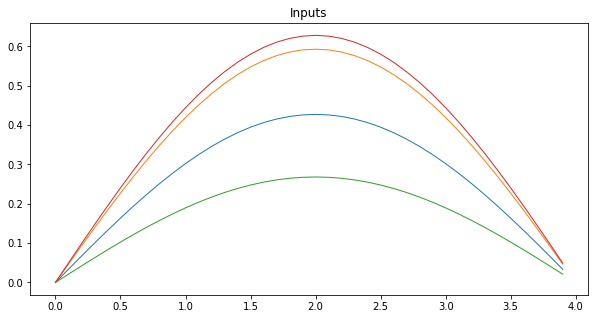

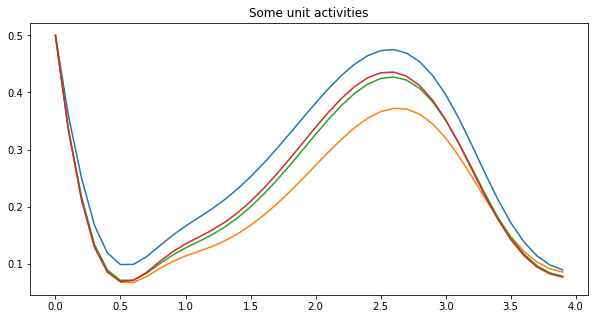

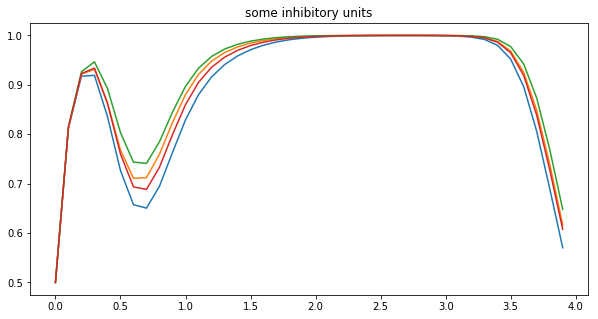

In [5]:
""" Some plots to get a general idea. """
ei.basic_plot()

<IPython.core.display.Javascript object>


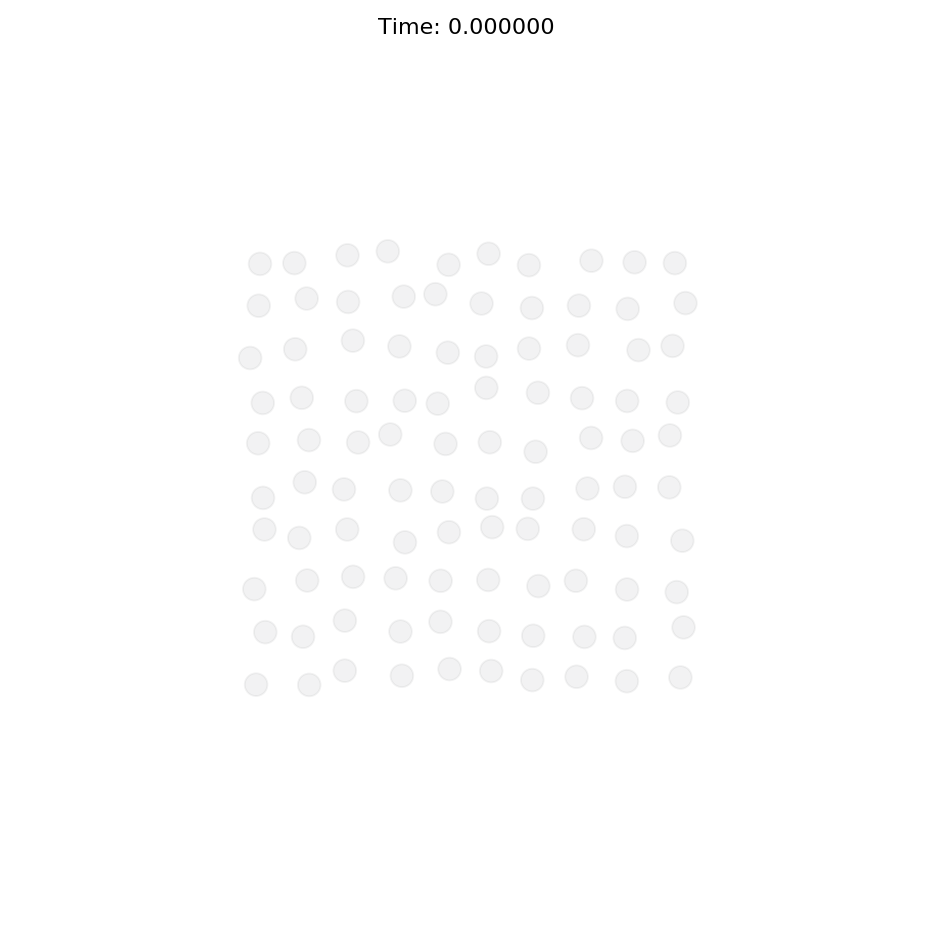

In [6]:
""" Visualize the activity after the simulation. """
act_ani = ei.activ_anim(0.8)
#act_ani.save('act_ani.mp4')

<IPython.core.display.Javascript object>


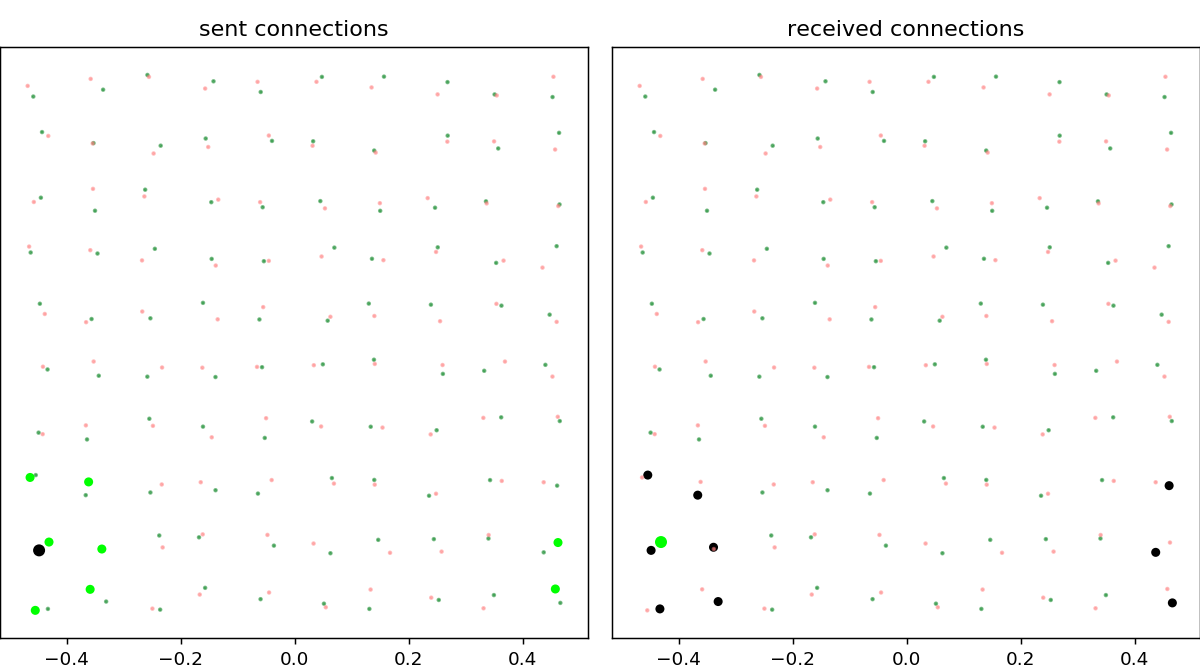

In [6]:
""" View the connections. """
conn_ani = ei.conn_anim(ei.inh, ei.units)